IEEE-CIS は、深層ニューラルネットワーク、ファジィシステム、進化的計算、群知能など、さまざまな AI および機械学習分野において活動しています。現在、彼らは世界有数の決済サービス企業である Vesta Corporation と提携し、不正防止業界における最適なソリューションを模索しています。

### 1.Import Libraries

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
%%time
warnings.simplefilter('ignore')
file = './data/train_transaction.csv'
train_transaction = reduce_mem_usage(pd.read_csv(file))

Mem. usage decreased to  8.36 Mb (72.2% reduction)
CPU times: total: 266 ms
Wall time: 273 ms


### 2.Visualize the Dataset

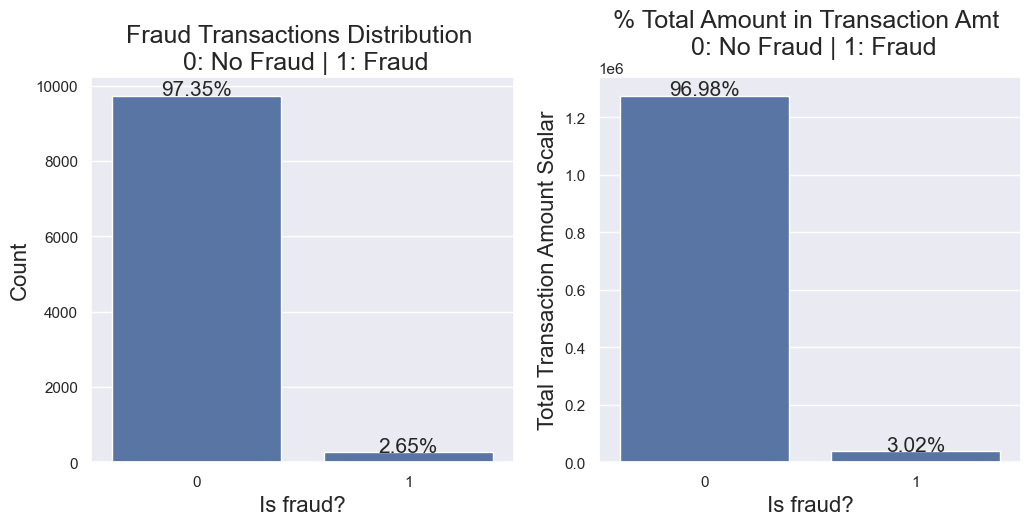

In [4]:
train_transaction['TransactionAmt'] = train_transaction['TransactionAmt'].astype(float)
total = len(train_transaction)
total_amt = train_transaction.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(12,5))

plt.subplot(121)
plot_tr = sns.countplot(x='isFraud', data=train_transaction)
plot_tr.set_title("Fraud Transactions Distribution \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr.set_xlabel("Is fraud?", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
    
percent_amt = (train_transaction.groupby(['isFraud'])['TransactionAmt'].sum())
percent_amt = percent_amt.reset_index()
plt.subplot(122)
plot_tr_2 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=percent_amt)
plot_tr_2.set_title("% Total Amount in Transaction Amt \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr_2.set_xlabel("Is fraud?", fontsize=16)
plot_tr_2.set_ylabel('Total Transaction Amount Scalar', fontsize=16)
for p in plot_tr_2.patches:
    height = p.get_height()
    plot_tr_2.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 

Text(0.5, 0.98, 'Individual ECDF Distribution')

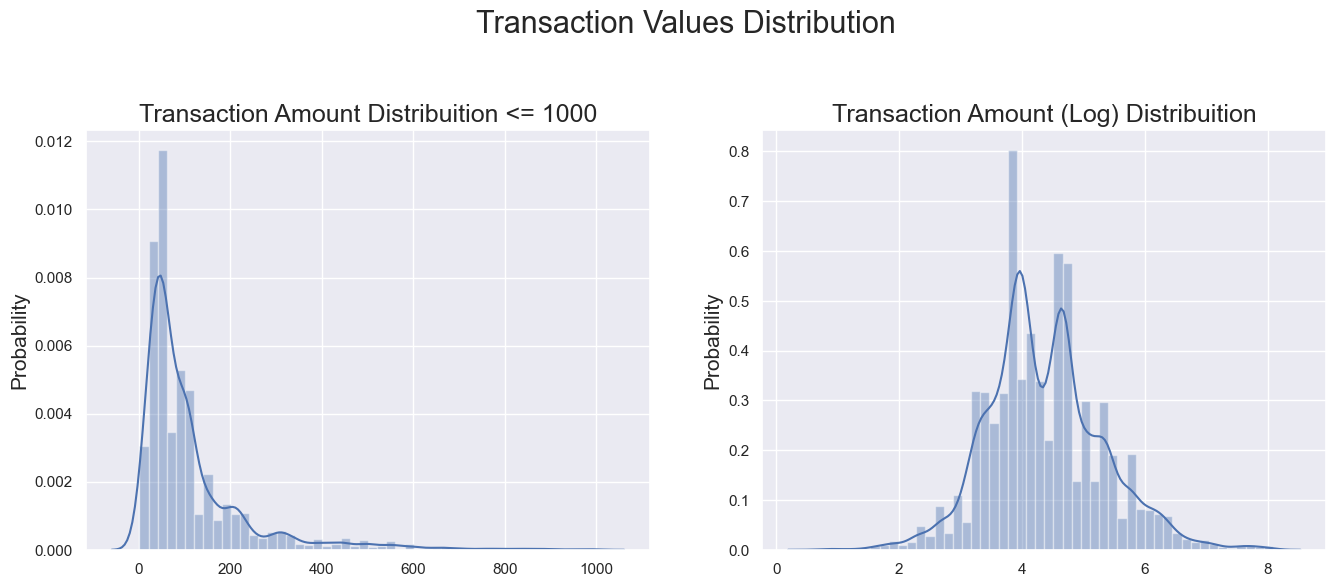

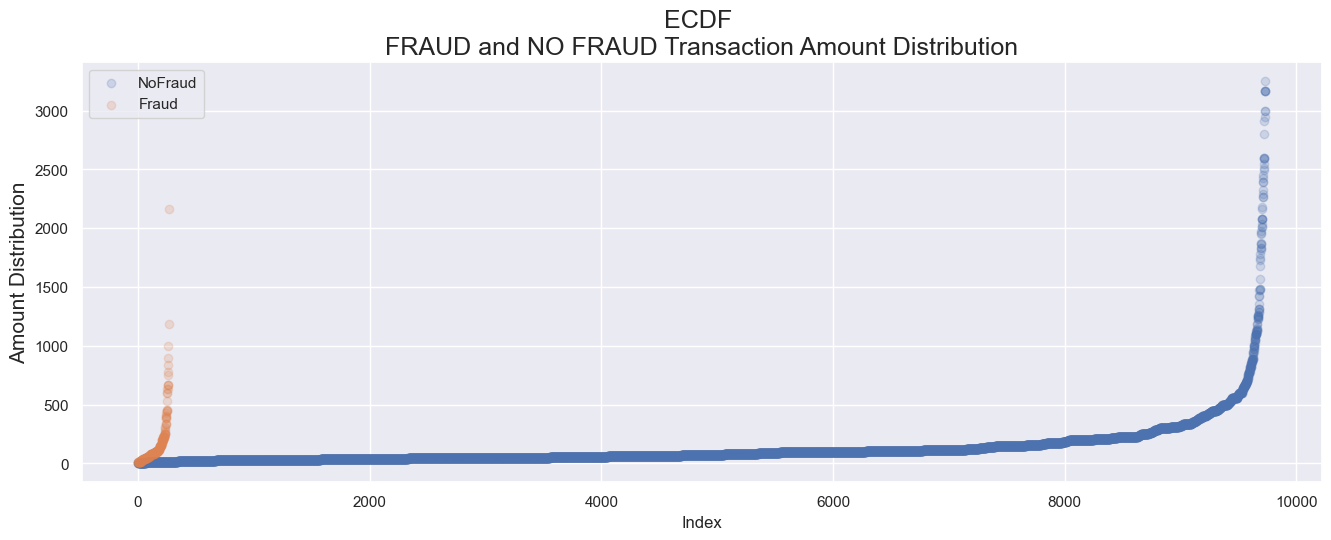

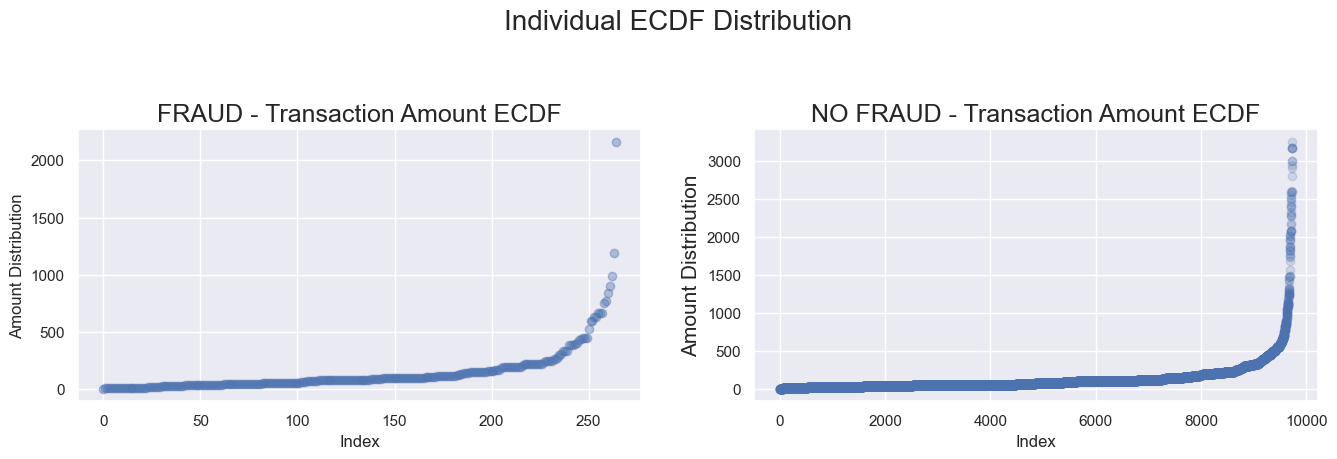

In [6]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
sub_plot_1 = sns.distplot(train_transaction[train_transaction['TransactionAmt'] <= 1000]['TransactionAmt'])
sub_plot_1.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
sub_plot_1.set_xlabel("")
sub_plot_1.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
sub_plot_2 = sns.distplot(np.log(train_transaction['TransactionAmt']))
sub_plot_2.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
sub_plot_2.set_xlabel("")
sub_plot_2.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))


plt.subplot(212)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
sub_plot_3= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
sub_plot_3 = plt.xlabel("Index")
sub_plot_3 = plt.ylabel("Amount Distribution", fontsize=15)
sub_plot_3 = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
sub_plot_4 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]), 
                 np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
sub_plot_5 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_5 = plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
sub_plot_5 = plt.xlabel("Index")
sub_plot_5 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=20)


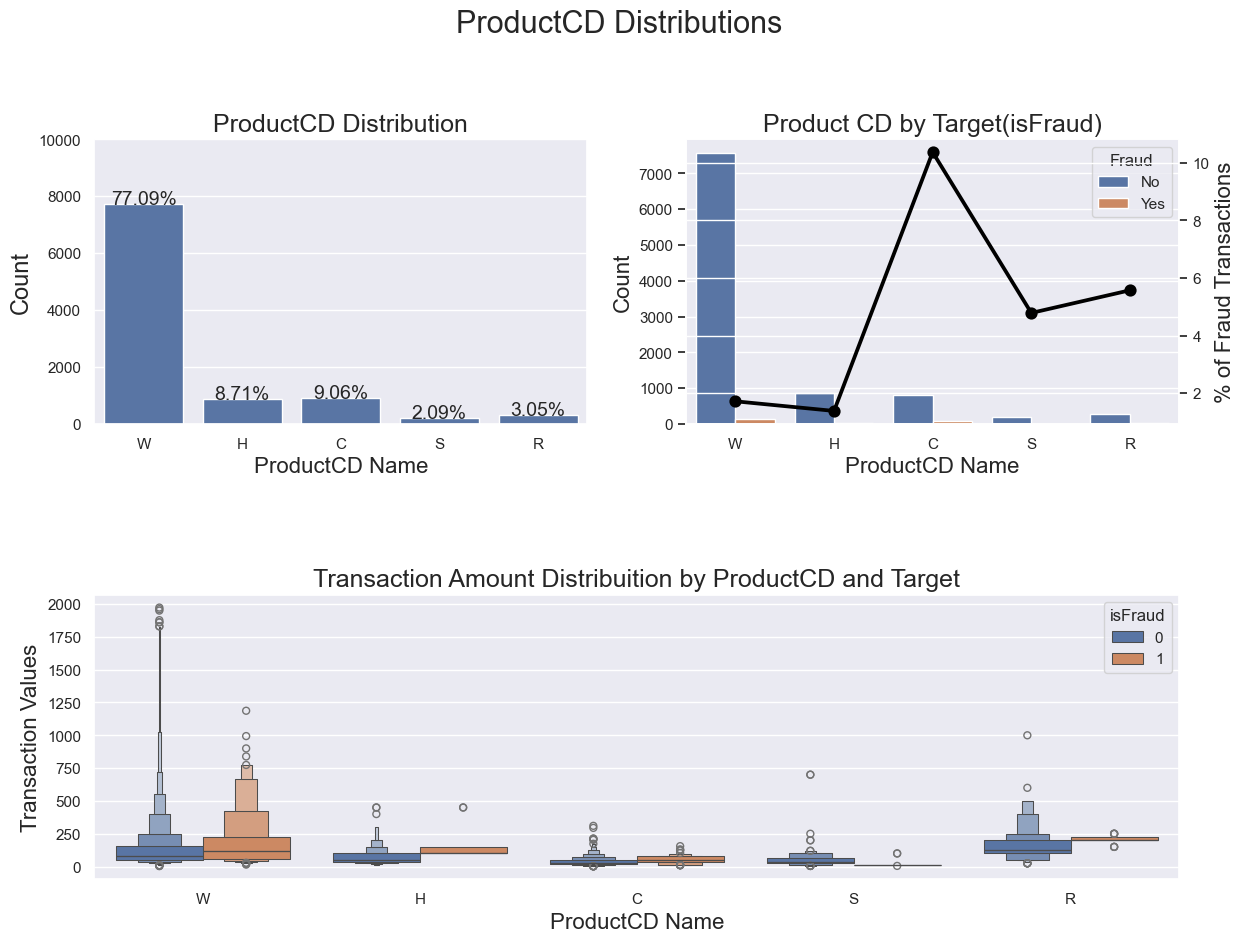

In [8]:
tmp = pd.crosstab(train_transaction['ProductCD'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='ProductCD', data=train_transaction)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

plot_1.set_title("ProductCD Distribution", fontsize=18)
plot_1.set_xlabel("ProductCD Name", fontsize=16)
plot_1.set_ylabel("Count", fontsize=17)
plot_1.set_ylim(0,10000)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
plot_2 = sns.countplot(x='ProductCD', hue='isFraud', data=train_transaction)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_2.twinx()
plot_2_2 = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)

plot_2.set_title("Product CD by Target(isFraud)", fontsize=18)
plot_2.set_xlabel("ProductCD Name", fontsize=16)
plot_2.set_ylabel("Count", fontsize=16)

plt.subplot(212)
plot_3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=18)
plot_3.set_xlabel("ProductCD Name", fontsize=16)
plot_3.set_ylabel("Transaction Values", fontsize=16)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

#### 2.4 Exploring M1-M9 Features

In [19]:
for columns in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    train_transaction[columns] = train_transaction[columns].fillna("Miss")
    
def ploting_dist_ratio(DataFile, Column, lim=2000):
    # tmp:不正率の計算
    categories = ['Miss', 'T', 'F']  # 実際に使いたいカテゴリをすべて入れてください
    tmp = pd.crosstab(DataFile[Column], DataFile['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{Column} Distributions ', fontsize=22)

    plt.subplot(121)

    # plot_1:各カテゴリの件数（棒グラフ）
    plot_1 = sns.countplot(x=Column, data=DataFile, order=[ 'F','Miss', 'T']) 
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    plot_1.set_title(f"{Column} Distribution\nCound and %Fraud by each category", fontsize=18)
    # plot_1_2:各カテゴリにおける不正率
    plot_1_2 = plot_1.twinx()
    plot_1_2 = sns.pointplot(x=Column, y='Fraud', data=tmp, order=categories,
                       color='black', legend=False, )
    plot_1_2.set_ylim(0,20)
    plot_1_2.set_ylabel("% of Fraud Transactions", fontsize=16)
    plot_1.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_1.set_ylabel("Count", fontsize=17)
    for p in plot_1_2.patches:
        height = p.get_height()
        plot_1_2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (train_transaction.groupby(['isFraud',Column])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    plot_2 = sns.boxplot(x=Column, y='TransactionAmt', hue='isFraud', 
                     data=DataFile[DataFile['TransactionAmt'] <= lim], order=list(tmp[Column].values))
    plot_2_2 = plot_2.twinx()
    plot_2_2 = sns.pointplot(x=Column, y='Fraud', data=perc_amt, order=list(tmp[Column].values),
                       color='black', legend=False, )
    plot_2_2.set_ylim(0,5)
    plot_2_2.set_ylabel("%Fraud Total Amount", fontsize=16)
    plot_2.set_title(f"{Column} by Transactions dist", fontsize=18)
    plot_2.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_2.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()

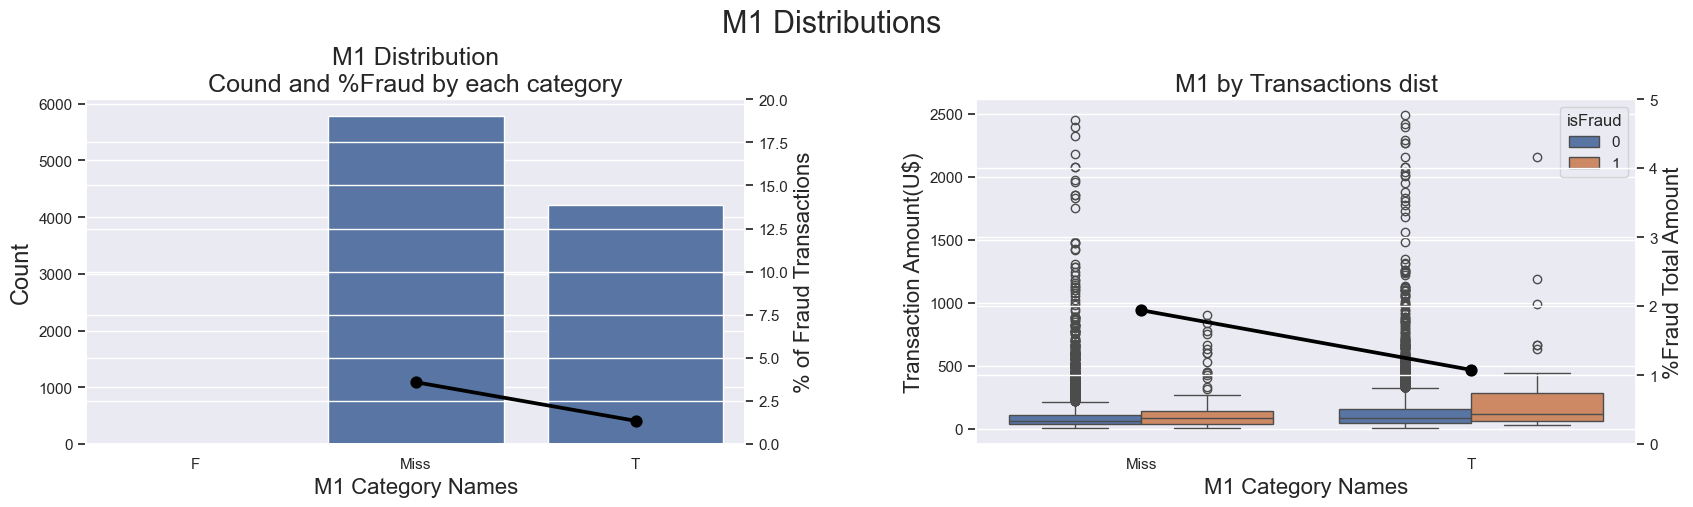

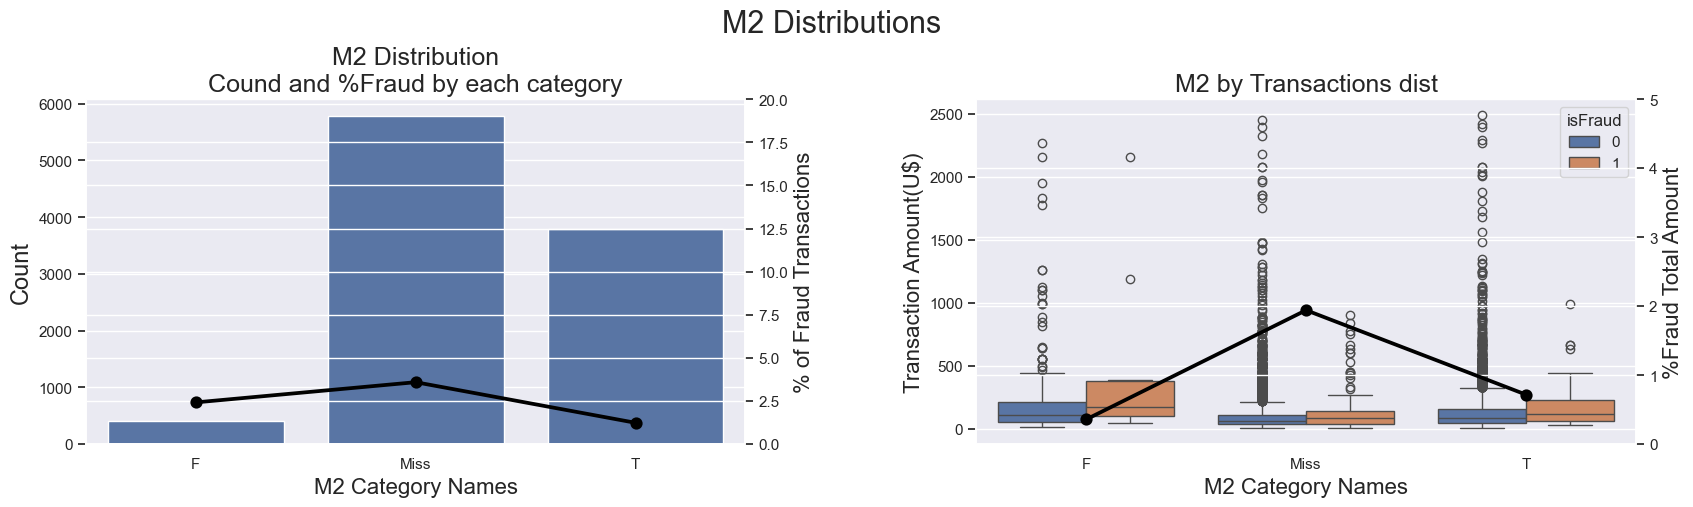

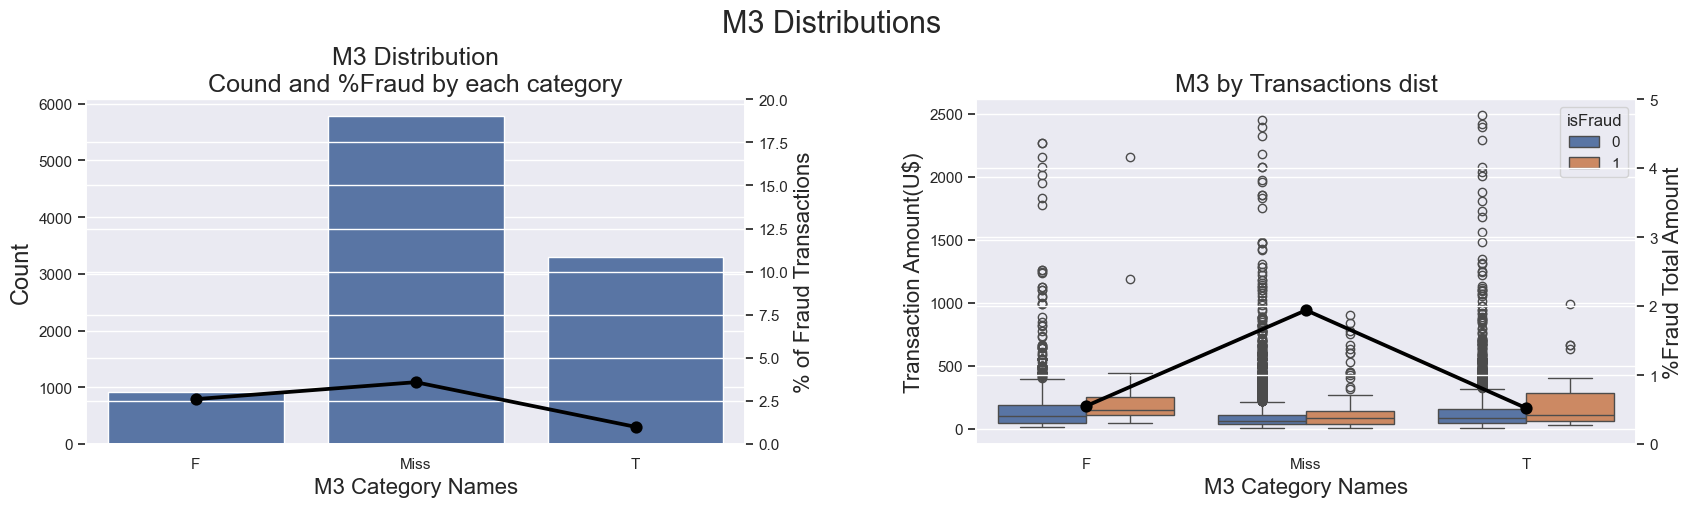

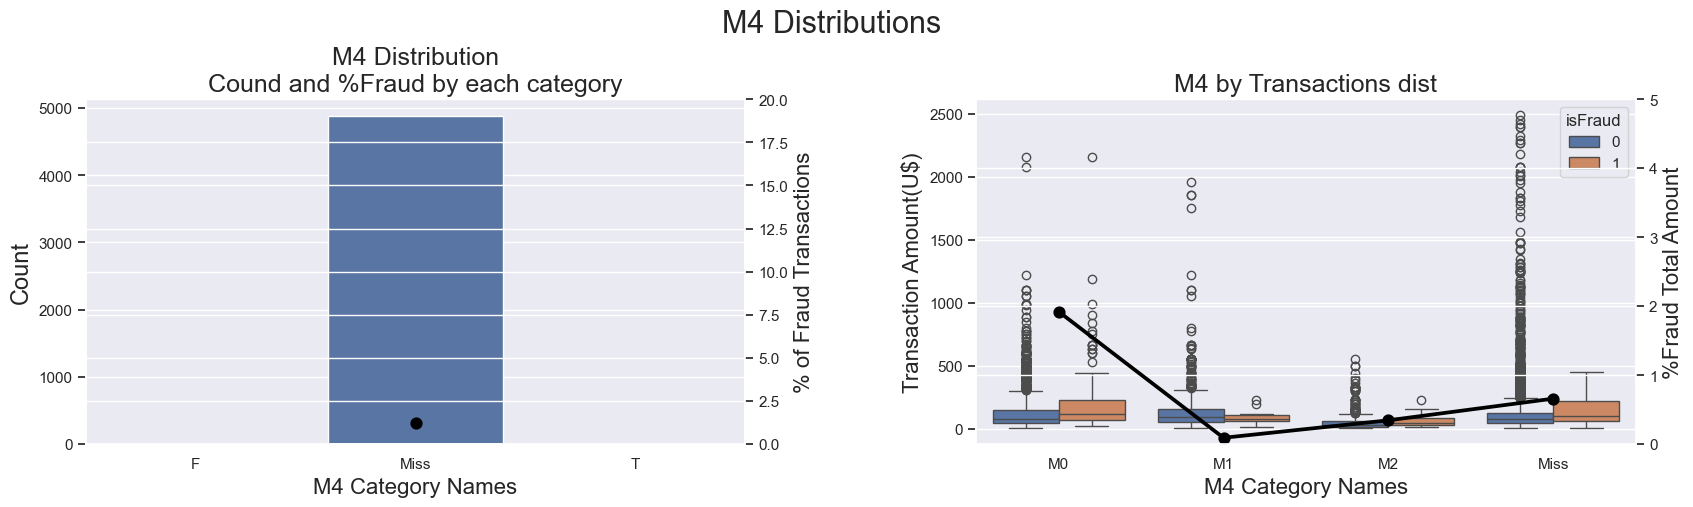

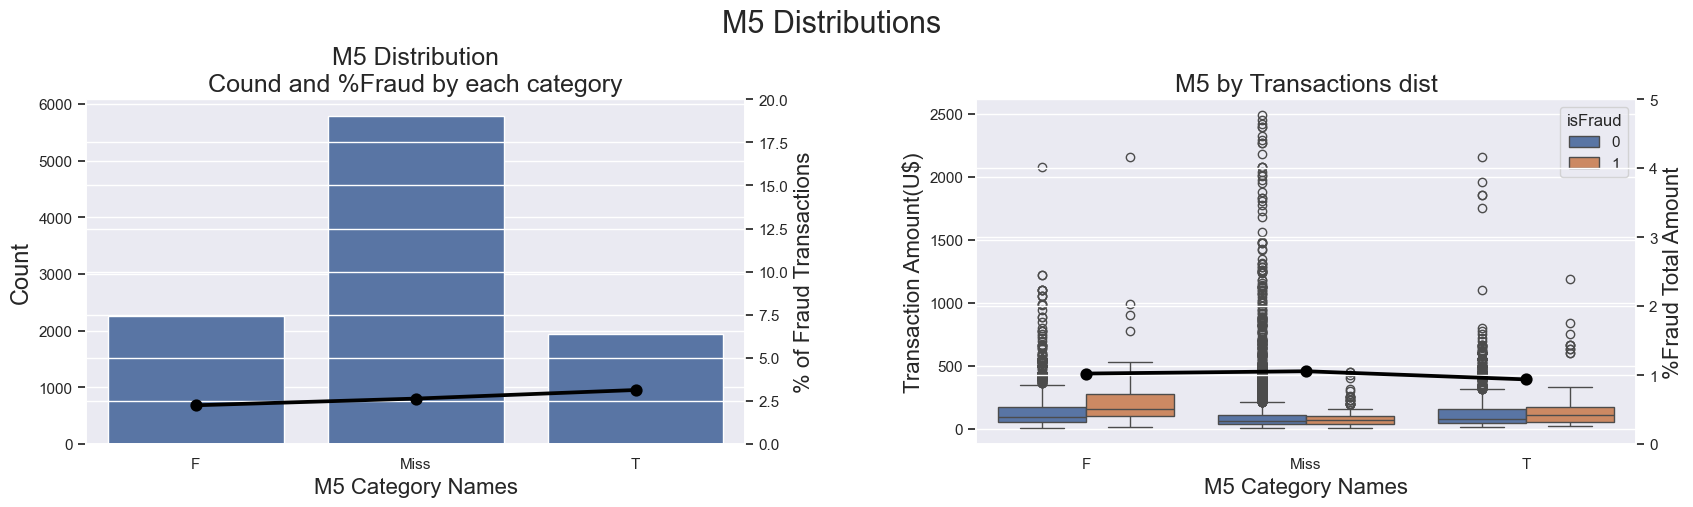

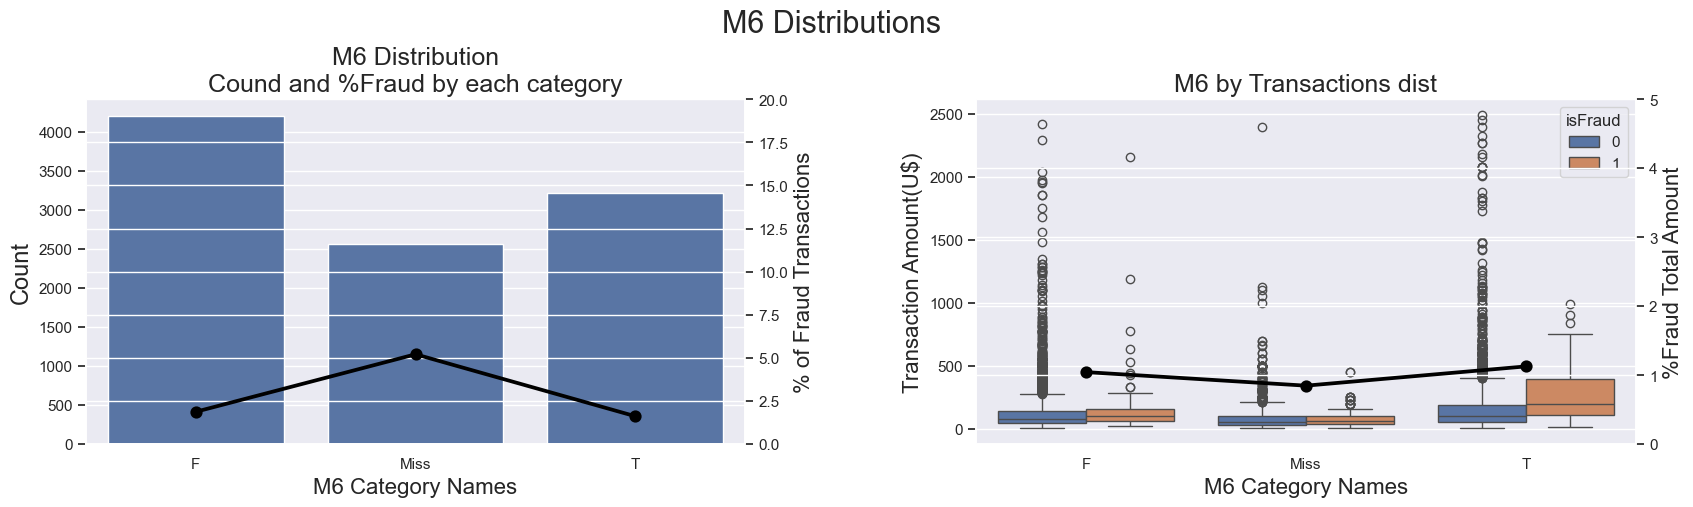

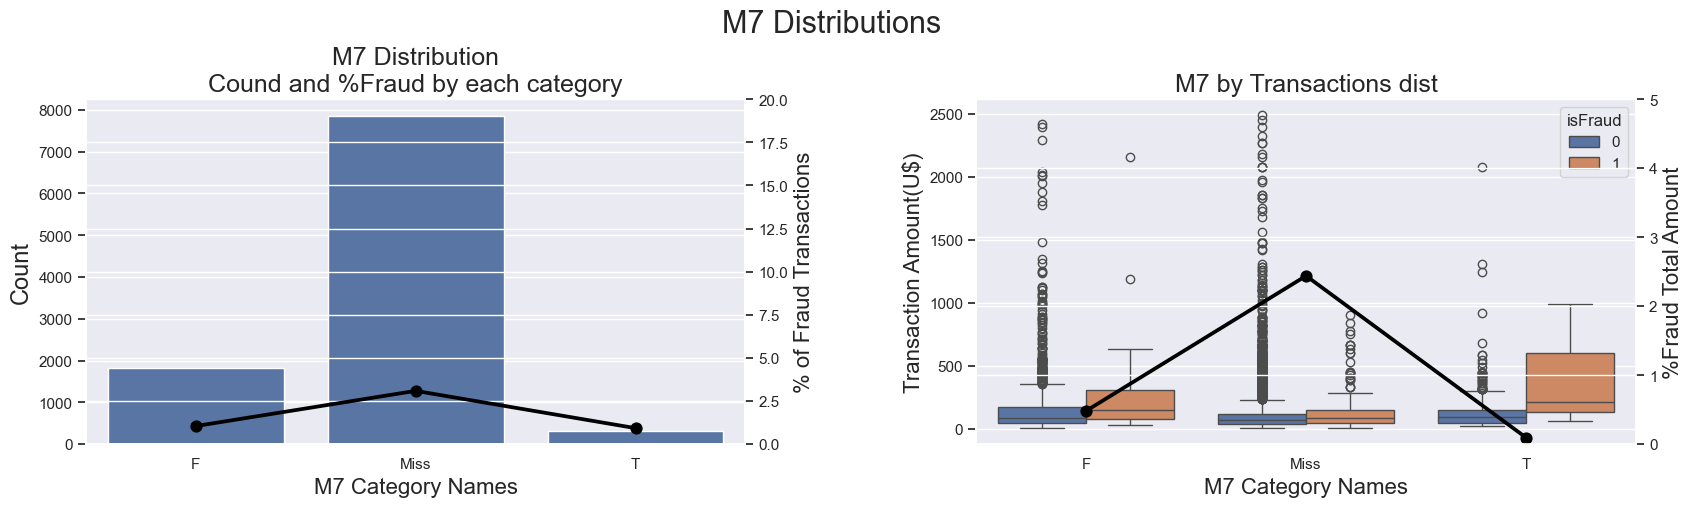

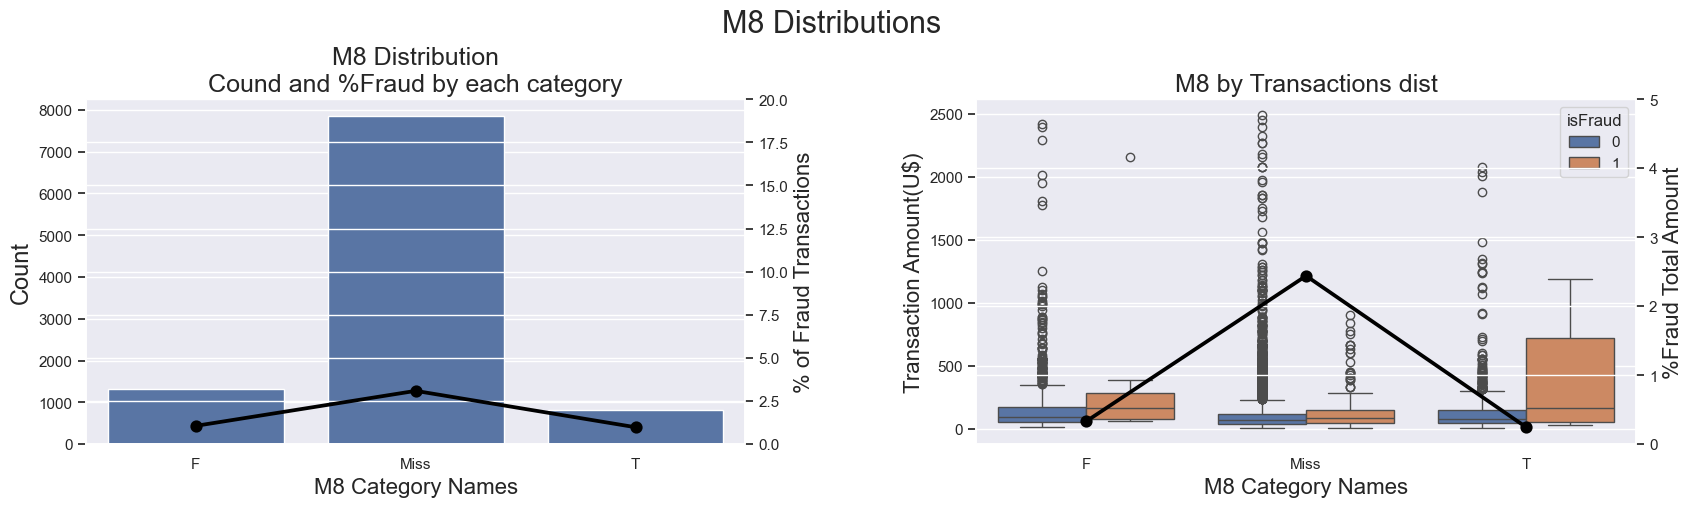

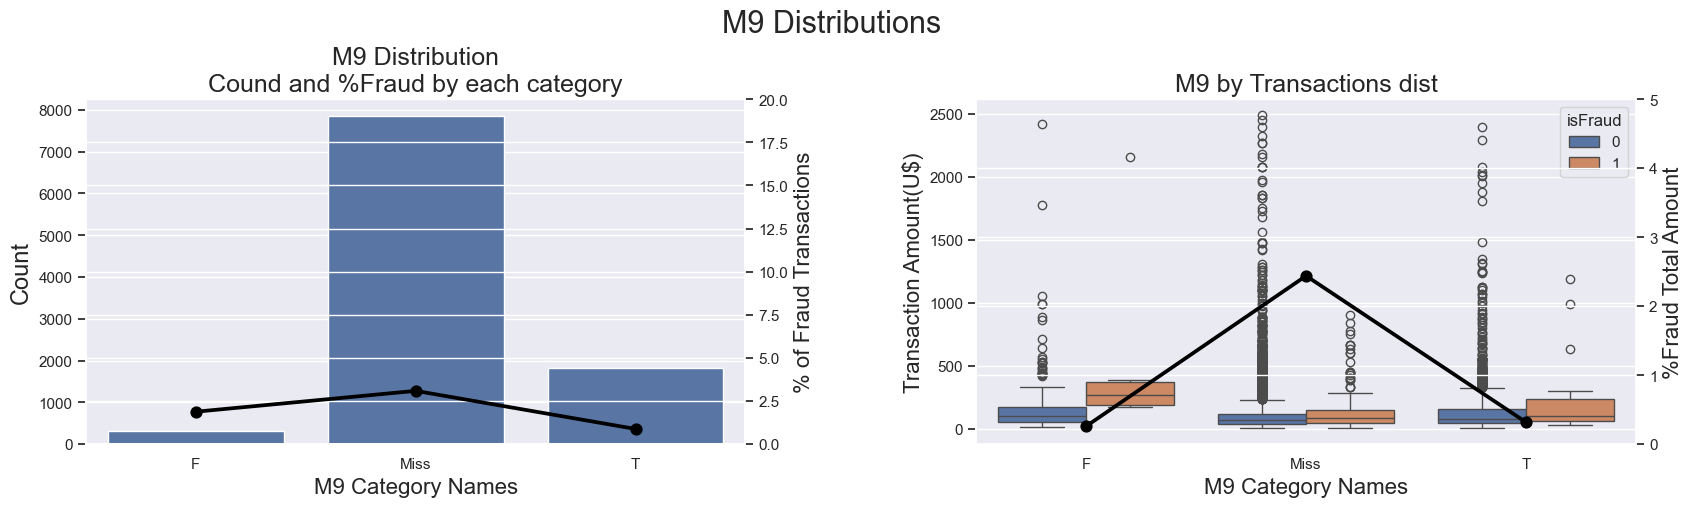

In [20]:
for columns in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(train_transaction, columns, lim=2500)

### 3.Feature Engineering

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

- 引数 seed: 固定する乱数シード。デフォルトは 0。

- 実行することで、Python全体のランダム性をシード値で固定する。



In [ ]:
import lightgbm as lgb

def make_predictions(tr_df, tt_df, features_columns, target, lgb_params, NFOLDS=6):
    """"
    LightGBM を用いたクロスバリデーション予測関数
    Group K-Fold を活用した汎化性能重視の訓練＆予測パイプライン
    """
    #クロスバリデーションの準備（GroupKFold）
    folds = GroupKFold(n_splits=NFOLDS)

    X,y = tr_df[features_columns], tr_df[target]    
    P,P_y = tt_df[features_columns], tt_df[target]  
    split_groups = tr_df['DT_M']

    tt_df = tt_df[['TransactionID',target]]    
    predictions = np.zeros(len(tt_df))
    oof = np.zeros(len(tr_df))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups=split_groups)):
        print('Fold:',fold_)
        tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
            
        print(len(tr_x),len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)  

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 200,
        )   
        
        pp_p = estimator.predict(P)
        predictions += pp_p/NFOLDS
        
        oof_preds = estimator.predict(vl_x)
        oof[val_idx] = (oof_preds - oof_preds.min())/(oof_preds.max() - oof_preds.min())
        
        del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
        gc.collect()
        
    tt_df['prediction'] = predictions
    print('OOF AUC:', metrics.roc_auc_score(y, oof))
    
    return tt_df

In [ ]:
import os, sys, gc, warnings, random, datetime
SEED = 42
seed_everything(SEED)
LOCAL_TEST = False
TARGET = 'isFraud'
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [ ]:
print('Load Data')
train_df = pd.read_pickle('../input/ieee-data-minification/train_transaction.pkl')

test_df = pd.read_pickle('./data/test_transaction.pkl')
train_identity = pd.read_pickle('./data/train_identity.pkl')
test_identity = pd.read_pickle('./data/test_identity.pkl')
    
base_columns = list(train_df) + list(train_identity)
print('Shape control:', train_df.shape, test_df.shape)

In [ ]:
for df in [train_df, test_df]:

    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    df['D9'] = np.where(df['D9'].isna(),0,1)

#### 3.5.Features elimination 

In [ ]:
from scipy.stats import ks_2samp

rm_cols = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
    TARGET,                          # Not target in features))
    'uid','uid2','uid3',             # Our new client uID -> very noisy data
    'bank_type',                     # Victims bank could differ by time
    'DT','DT_M','DT_W','DT_D',       # Temporary Variables
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
]

features_check = []
columns_to_check = set(list(train_df)).difference(base_columns + rm_cols)


- ks_2samp(x, y) は、2つのサンプルが同じ分布から来ているかどうかを検定する関数（Kolmogorov-Smirnov検定）。

- columns_to_check は、base_columns や rm_cols（基本的に使わないカラム）を除外した、検定対象の特徴量名のリストです。



In [ ]:
for i in columns_to_check:
    features_check.append(ks_2samp(test_df[i], train_df[i])[1])

- 各特徴量について、train と test の分布の違いを検定。

- 返り値の [1] は p値です。p値が 小さいほど分布が異なる（一般に 0.05 未満で「有意差あり」とみなされる）



In [ ]:
features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
features_discard = list(features_check[features_check==0].index)

- 検定結果（p値）を Series にまとめて、p値の昇順にソート。

- p値 = 0 だった特徴量（明らかに分布が違う）を除外リストに追加。

In [1]:
features_discard = [] 

In [ ]:
features_columns = [col for col in list(train_df) if col not in rm_cols + features_discard]

### 4.Light GBM

In [ ]:
lgb_params = {
                'objective':'binary',
                'boosting_type':'gbdt',
                'metric':'auc',
                'n_jobs':-1,
                'learning_rate':0.01,
                'num_leaves': 2**8,
                'max_depth':-1,
                'tree_learner':'serial',
                'colsample_bytree': 0.85,
                'subsample_freq':1,
                'subsample':0.85,
                'n_estimators':2**9,
                'max_bin':255,
                'verbose':-1,
                'seed': SEED,
                'early_stopping_rounds':100,
                'reg_alpha':0.3,
                'reg_lamdba':0.243,
                'early_stopping_rounds':100

            } 
test_predictions = make_predictions(train_df, test_df, features_columns, TARGET, lgb_params, NFOLDS=6)